# TMA4320 Biofysikk prosjekt

__Introduksjon__

Polymerer spiller en stor rolle i vår hverdag, et av våre mest brukte materialer, plastikk, er en form for syntetisk polymer. I tillegg til syntetiske polymerer finnes naturlige polymerer som fremstilles i levende organismer. Eksempler på naturlige polymerer er RNA, DNA og proteiner. Fra et biofysisk ståsted er det derfor meget interessant å studere polymerer og deres dannelse. Eksempelvis er man interessert i å studere dannelsen av DNA, da de inneholder arvestoff som er en oppskrift på hvordan organismer skal se ut og fungere. For at DNA skal få plass inne i celler er viktig at de pakkes kompakt sammen, et konsept vi skal se på senere i oppgaven. 

Polymerer dannes av en samling monomerer bundet sammen med kovalente bindinger. Her kommer vi til å undersøke hvordan både monomerer og polymerer oppfører seg under ulike betingelser. Til dette benytter vi oss av Monte Carlo metoden, mer spesifikt Metropolis algoritmen. Ved disse undersøkelsene er Metropolis algoritmen passende ettersom den benytter seg av tilfeldig utvalg. 

In [1]:
# Importer nyttige biblioteker
import numpy as np
import matplotlib.pyplot as plt
import random

# Importerer numba for å hjelpe kode kjøre raskere
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

# Remove annoying deprecation warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [2]:
# Noen konstanter
relative_permittivity = 78 
permittivity = 8.85*10**(-12) # Permitivitet i vakuum

distance_between_grid_points = 23*10**(-6)  # Avstanden mellom grid i oppgave 1
distance_between_grid_points_2 = 91*10**(-6) # Avstanden mellom grid i oppgave 2

k_B = 1.38 * 10**(-23) # Boltzmannskonstant
e = 1.6 *10**(-19) # Elementær ladningen

# Alfa; som definert i oppgavesettet
alfa = (e**2)/(4*np.pi*permittivity*relative_permittivity*distance_between_grid_points**2) # Opppgave 1
alfa_2 = (e**2)/(4*np.pi*permittivity*relative_permittivity*distance_between_grid_points_2**2) # Oppgave 2

Ved utvikling av koden fant vi det nyttig med en hjelpefunksjon. Målet med denne var å ta inn et vilkårlig grid og returnere den standardiserte versjonen av gridet. Med standarisert grid skal det her menes et grid kun bestående av elementer med verdiene -1, 0 eller 1. Her vil elementene med verdiene $\pm$ 1 sikte til monomerer med positiv/negativ ladning, og elementer med verdien 0 tilsvarer løsningsmiddel.

In [3]:
@jit(nopython=True)
def standardized_grid(grid):   #En hjelpefunksjon som returnerer et grid som kun inneholder -1, 0 og 1
    N = len(grid)
    
    # Iterer gjennom alle punktene i griddet, gir alle negative verdier verdien -1, og alle positive verdien 1.
    # Punktene med verdien 0 vil forbli lik
    for i in range(N):
        for j in range(N):
            if grid[i][j] < 0:
                grid[i][j] = -1 
            elif grid[i][j] > 0:
                grid[i][j] = 1
    return grid

Funksjonen under (Oppgave 1a) tar inn to parametre, N = Størrelse på grid og M = antall monomerer, og returnerer et grid med tilfeldige plasserte monomerer. I dette griddet er 2M verdier som er ulik 0, M av disse har en negtiv verdi og M har positiv verdi. Tilslutt genereres et grid, monomer_grid, som kommer til å bli brukt senere.

In [4]:
# Oppgave 1a
@jit(nopython=True)
def generate_grid_of_monomers(N, M):
    #N: Størrelse på grid
    #M: Antall monomerer
    
    grid = np.zeros((N,N), dtype=np.dtype('i2')) #Lager tomt grid av størrelse N*N

    m = -M  # Finner start verdi for whileløkka
    
    while m <= M:
        random_x = random.randint(0,N-1)   #Finner tilfeldige x og y koordinater
        random_y = random.randint(0,N-1)

        if grid[random_x][random_y] == 0:  # Dersom ruta er tom, fyller vi den
            grid[random_x][random_y]= m
            m += 1                         # Beveger oss videre til neste verdi
    return grid

monomer_grid = generate_grid_of_monomers(10, 10)

visualize_grid er en funksjon som tar inn et grid, en tittel og standard (True/False), hvorav de to siste er valgfrie parametre. Målet med funksjonen er å visualisere gridet vha. pcolormesh. Under kodeblokken inkluderes en figur av gridet definert i Oppgave 1a. Dersom en ønsker en spesiell tittel kan dette tas inn som en parameter, hvis ikke vil tittelen være "Monomere". Dersom en ønsker å plotte et standardisert grid kan dette spesifiseres. 

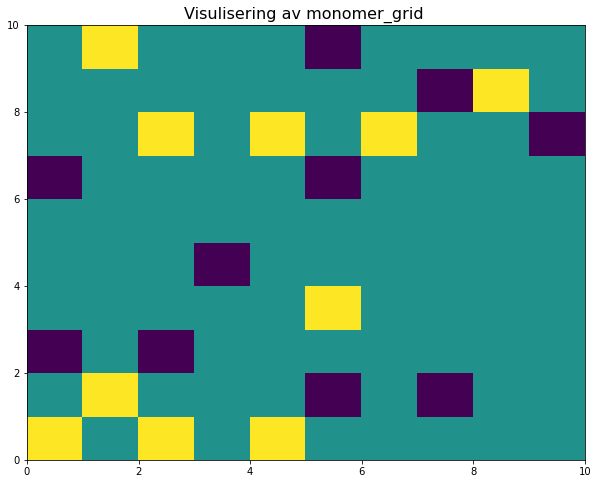

In [5]:
# Oppgave 1b
def visualize_grid(grid_visualize, title = "Monomere", standard = False):
    grid=grid_visualize.copy()
    if standard:
        grid = standardized_grid(grid)
    N = len(grid)

    plt.figure(figsize=(10, 8))   #Bestemmer figurstørrelsen
    plt.pcolormesh(grid[::-1,])   # Plotter griden grid[::-1,]
    plt.title(title,fontsize=16)
    
visualize_grid(monomer_grid, "Visulisering av monomer_grid " , True) # Plotter standardisert monomer_grid

In [7]:
# Oppgave 1c
@jit(nopython=True)
def get_neighbors_coordinates(N, i, j):
    # N: Lengden til grid
    # i, j: Matrise indekser
    neighbor_coordinates = [[(i+1) % N, j], [i, (j+1) % N], [(i-1) % N, j ], [i, (j-1) % N ]]
    return neighbor_coordinates #returnerer naboene til koordinatet tatt inn

In [8]:
# Oppgave 1d
@jit(nopython=True)
def total_energy(grid_energy):
    grid = grid_energy.copy() #Lager kopi av den innhentede gridden
    total_energy = 0 
    N = len(grid)
    
    grid = standardized_grid(grid) # Kun interesert i fortegn, standardiserer gridet
    
    i = 0
    j = 0
    
    # Summerer opp energien mellom alle naboene, dvs mellom alle monomerer som er i kontakt med hverandre
    while i < N:
        while j < N:
            neighbors = get_neighbors_coordinates(N, i, j)
            n = 0
            while n < 4:
                total_energy += grid[i][j]*grid[neighbors[n][0]][neighbors[n][1]]*alfa 
                n+=1
            j += 1
        j = 0
        i += 1
        
    #Tar hensyn til at samme koordinat telles to ganger, men kun 1 bånd eksisterer
    total_energy = total_energy/ 2 


    return total_energy
print("Den totale energien for monomer_grid er: " , total_energy(monomer_grid) , "J")

Den totale energien for monomer_grid er:  -5.5787455813607816e-21 J


In [9]:
# Oppgave 1e
@jit(nopython=True)
def Monte_Carlo(N_S,N, M,T, grid):
    # N_S = Antall steg
    # N = Størrelse på grid
    # M = Antall monomerer
    # T = Temperatur
    
    epsilon = np.zeros(N_S - 1, dtype=np.dtype('double'))  # En tom liste over energiverdier
    E = total_energy(grid) #Regner ut den totale energien av den orginale griden
    epsilon[0] = E  #Setter det første elementet i den tomme lista over energier lik startenergien
    
    for i in range(0,N_S-1):
        epsilon[i] = total_energy(grid) # Finner energien til griden
        list_of_positions = np.argwhere(grid) #Finner monomerene sin plassering i griden
        
        # Velger en tilfeldig monomer fra listen over monomerenes posisjoner
        plassering_1 = random.randint(0,len(list_of_positions)-1)
        random_monomer_position = list_of_positions[plassering_1]
        
        #Finner naboene til den valgte monomeren over
        neighbors = get_neighbors_coordinates(N, random_monomer_position[0], random_monomer_position[1])
        
        # Velger en tilfeldig nabo (altså retning) til monomeren
        plassering_2 = np.random.randint(0,4)
        random_direction = neighbors[plassering_2]
        
        #Sjekker om den valgte naboen er ulik null, da en ikke kan flytte monomeren til en annen monomer
        if grid[random_direction[0]][random_direction[1]] != 0: 
            pass
        
        else:
            new_grid = grid.copy() # Lager en kopi av griden
            new_grid[random_direction[0],random_direction[1]] = grid[random_monomer_position[0],random_monomer_position[1]]
            new_grid[random_monomer_position[0],random_monomer_position[1]] = 0 # Flytter monomeren
            
            E_new = total_energy(new_grid) # Finner energien til den nye griden
            
            if E_new < epsilon[i]: #Sjekker med energiene om vi skal forflytte oss til den nye gridden
                grid = new_grid
            elif np.random.random() < np.exp(-(1/(k_B*T))*(E_new - epsilon[i])):
                grid = new_grid
         
    return grid, epsilon


In [10]:
# Oppgave 1f
monomer_grid_before_MC = generate_grid_of_monomers(15, 25) # Finner stat griden

monomer_grid_MC_200K, E_200K= Monte_Carlo(50000,15,25,200, monomer_grid_before_MC) #Finner griden og energiene etter gjennomført Monte Carlo ved 200 K
monomer_grid_MC_500K, E_500K= Monte_Carlo(50000,15,25,500, monomer_grid_before_MC) #Finner griden og energiene etter gjennomført Monte Carlo ved 500 K

#Lagrer griddet ved 200 K
np.savez("Visualisering_av_gridet_etter_MC_metoden_ved_200_K.npz",monomer_grid_MC_200K)

Vi kjører to simulasjoner av Monte Carlo ved temperaturene 200 K og 500 K, der førstnevnte lagres til senere bruk. Under plottes de ulike griddene for visualisere endringen som oppstår under Monte Carlo ved de ulike temperaturene

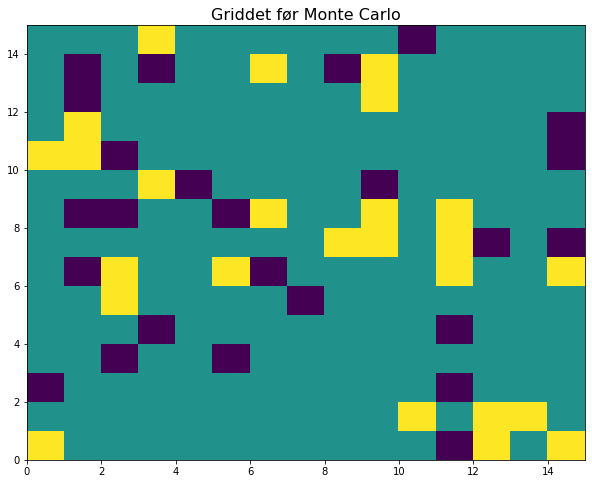

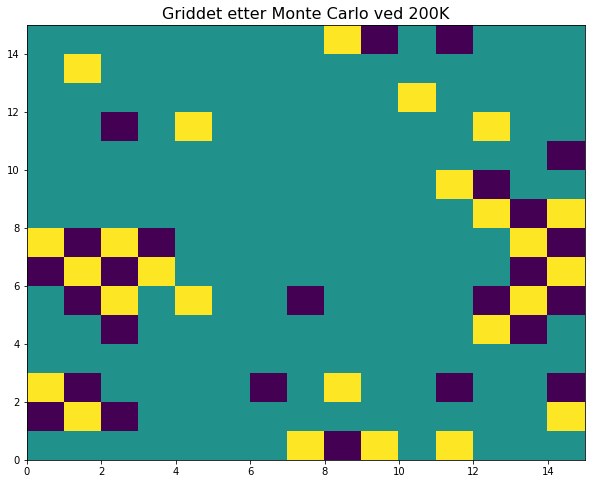

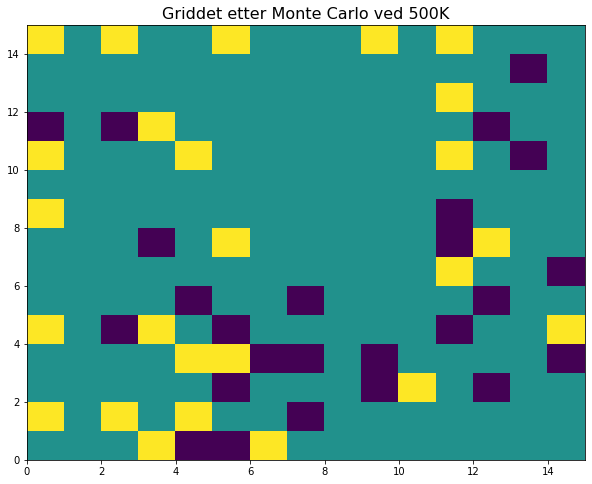

In [11]:
# Plotter griddene
visualize_grid(monomer_grid_before_MC, "Griddet før Monte Carlo", True) 

visualize_grid(monomer_grid_MC_200K, "Griddet etter Monte Carlo ved 200K", True)

visualize_grid(monomer_grid_MC_500K,"Griddet etter Monte Carlo ved 500K", True)


Under plottes energien til de to simulasjonene som funksjon av tid/steg. Vi ser at energien til simulasjonen utført ved 500 K ligger høyere enn simulasjonen ved 200K. Energien til gridet etter gjennomført Monte Carlo ved 500K stabilisere seg relativt raskt om en energi rundt - 20. Ved å se på funksjonen kan vi konkludere med at $t_{equil}$ ligger et sted mellom 5000 og 10000 steg. For simulasjonen ved 200K stabiliseres energien rundt -57, $t_{equil}$ rundt 25000 steg. I Monte Carlo er det to muligheter for en forflytning. Den første er at energien etter forflytningen vil være mindre enn nåværende energien. Den andre muligheten er en "tilfeldig forflytning". Denne forflytningen finner sted dersom følgende ulikhet er oppfylt: 
$$e^{-{\frac{1}{k_{b}T}}\cdot \Delta E} > p$$
Hvor p er et tilfeldig tall mellom 0 og 1, og vil variere mellom hvert Monte Carlo Step. Ved høye temperaturer ser vi at $e^{-{\frac{1}{k_{b}T}}\cdot \Delta E}$ vil få en større verdi enn ved lave temperaturer. Dette vil medføre at flere ikke energigunstige forflytninger vil finne sted. Monomerene vil forsøke å klynge seg sammen, da dette vil minimere energi. Ved lave temperaturer vil disse klyngene være vanskelige å komme seg bort fra, siden de ugustige forflytningene har en lav sannsynlighet for å finne sted. 

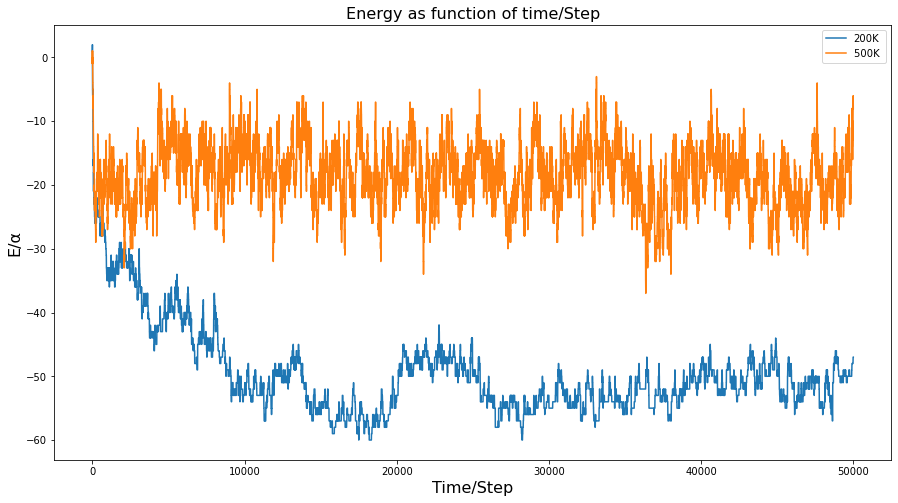

In [12]:
plt.figure(figsize=(15, 8))
plt.plot(E_200K/alfa) # 200 K
plt.plot(E_500K/alfa) # 500 K
plt.legend(['200K', '500K '])
plt.ylabel('E/α',fontsize=16 )
plt.xlabel("Time/Step", fontsize=16)
plt.title("Energy as function of time/Step",fontsize=16)
plt.show()

In [13]:
# Oppgave 1g
@jit(nopython=True)
def cluster_grid(grid, i = 0, j = 0, value = 10):
    N = len (grid)
    
    if (grid[i][j] == -1) or (grid[i][j] == 1) or (grid[i][j] == 0):  #Sjekker som monomeren allerede har en tilegnet verdi
        if grid[i][j] != 0: #Sjekker at det ikke er løsning
            grid[i][j] = value # Tilegner punktet en verdi
            neighbors = get_neighbors_coordinates(N,i,j) # Finner naboene
            for n in range(4):
                cluster_grid(grid, neighbors[n][0], neighbors[n][1], value) #Bruker rekursjon til å gi alle naboer, som ikke er løsning samme verdi
    return grid

@jit(nopython=True)
def iteration (grid): #Kjører gjennom alle posisjonene
    N = len (grid)
    value = 1
    for i in range(N):
        for j in range(N):
            if (grid[i][j] == -1) or (grid[i][j] == 1) or (grid[i][j] == 0): #Sjekker om gridden allerede har en tilegnet verdi
                if (grid[i][j] == -1) or (grid[i][j] == 1): #Tilegner monomerer en verdi
                    value += 1
                cluster_grid(grid, i , j, value) #Tilegner nabomonomerene den samme verdien
    return grid

Text(0.5, 0.98, 'Grid før og etter clustering\nMonte Carlo v. 200 K')

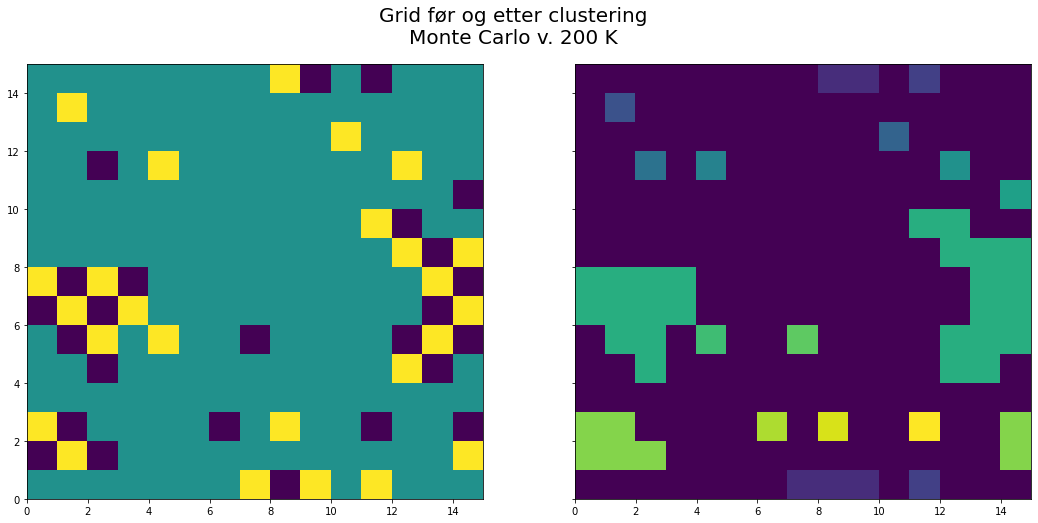

In [15]:
grid_200K = np.load("Visualisering_av_gridet_etter_MC_metoden_ved_200_K.npz") #Henter ut den lagre verdien for MC ved 200 K
grid_200K = grid_200K['arr_0']
grid_200K = standardized_grid(grid_200K)

#plotter griddet før og etter clustering ved siden av hverandre
fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
axs[0].pcolormesh(grid_200K[::-1,])
axs[1].pcolormesh(iteration(grid_200K)[::-1,])
fig.suptitle('Grid før og etter clustering\nMonte Carlo v. 200 K', size = '20')

In [16]:
# Oppgave 1h
T_max = 100000    #Oppgitte verdier for oppgaven
s = 1/200
C = 10000
T_h = 1000
T_l = 100
t_r = 1000
n = 50  # Valg verdi av n

@jit(nopython=True)
def t_equil(T):
    return T_max*np.exp(-s*(T-T_l)) + C #Oppgitt verdi for t_equil

In [17]:
@jit(nopython=True)
def cluster_size(grid):
    N = len (grid)
    list_of_cluster_sizes = [] #Lager en tom liste over størrelsene til clusterene
    list_of_values = [] # Lager en tom liste over de ulike verdiene som ble tilegnet clusterene i funksjonene cluster_grid og itereration
    
    for i in range(N):      #Itererer gjennom alle koordinatene
        for j in range(N):
            
            if grid[i][j] != 0:   #Sjekker om vi har en monomer i koordinatet
                if grid[i][j] in list_of_values:  # Sjekker om vi allerede har begynt å måle størrelsen på clusteren
                    
                    # Øker størrelsen på gridden med 1 dersom vi allerede har "begynt" å måle størrelsen på clusteren
                    list_of_cluster_sizes[grid[i][j] - 2] = list_of_cluster_sizes[grid[i][j] - 2] + 1
                else:
                    list_of_values.append(grid[i][j]) #Dersom vi ikke hadde begynt å måle cluster gjør vi det her
                    list_of_cluster_sizes.append(1)   #Legger til verdien i values og 1 til clusteren, ettersom det er det første elementet

    mean_cluster_size_value = 0    # Finner den gjennomsnittlige størrelsen på clusterene
    for n in range (len(list_of_cluster_sizes)):
        mean_cluster_size_value += list_of_cluster_sizes[n]
    
    mean_cluster_size_value= mean_cluster_size_value/len(list_of_cluster_sizes)
    
    return mean_cluster_size_value


In [20]:
grid_mean_size1 = generate_grid_of_monomers(15, 25) #Lager to grid for å sammenligne mean cluster size
grid_mean_size2 = generate_grid_of_monomers(15, 25)

temperatures = [] #Lager tomme lister
sizes1 = []
sizes2 = []

for T in range(100,1001,100):
    temperatures.append(T)
    N_s = int(t_equil(T)+t_r*n )
    
    grid_mean_size1_MC, E_mean_size1 = Monte_Carlo(N_s,15, 25,T, grid_mean_size1) #Gjennomfører Monte Carlo
    grid_mean_size2_MC, E_mean_size2 = Monte_Carlo(N_s,15, 25,T, grid_mean_size2)
    
    grid_mean_size1_clustered  = iteration(standardized_grid(grid_mean_size1_MC)) #Lager et clustered grid av begge
    grid_mean_size2_clustered  = iteration(standardized_grid(grid_mean_size2_MC))
    
    sizes1.append(cluster_size(grid_mean_size1_clustered)) #Bruker clustered grid til å finne gjennomsnittelig gridsize og legger det til i lista 
    sizes2.append(cluster_size(grid_mean_size2_clustered))

Text(0.5, 1.0, 'Gjennomsnittelig clustersize')

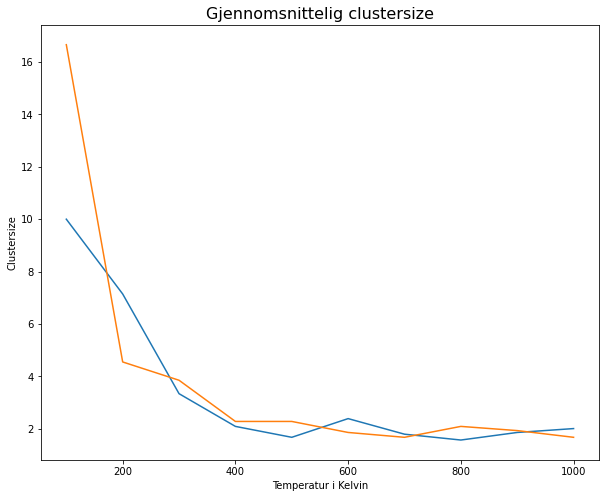

In [21]:
plt.figure(figsize=(10, 8))   #Bestemmer figurstørrelsen
plt.plot(temperatures,sizes1) #Plotter den gjennomsnittlige griddstørrelsen til det første griddet sfa. temperatur
plt.plot(temperatures,sizes2) #Plotter den gjennomsnittlige griddstørrelsen til det andre griddet sfa. temperatur

plt.xlabel("Temperatur i Kelvin")
plt.ylabel("Clustersize")
plt.title("Gjennomsnittelig clustersize",fontsize=16)


Som vi snakket om tidligere er det mest energimessig gunstig for monomerene å klynge seg sammen og gitt muligheten vil de helst gjøre dette. Allikvel er det en viss sannsynlighet for at monomerene vil flytte seg på en energimessig ugunstig måte. Denne forflytningen finner sted dersom følgende ulikhet er oppfylt: 
$$e^{-{\frac{1}{k_{b}T}}\cdot \Delta E} > p$$
hvor p er et tilfeldig tall mellom 0 og 1. Ved høye temperaturer er det større sannsynlighet for at en ugunstig forflytning ettersom $e^{-{\frac{1}{k_{b}T}}\cdot \Delta E}$ tar en større verdi. Altså vil det med høyrere temperatur oppstå færre klynger ettersom flere ugunstige forflytninger vil oppstå. Valg av n blir en balansegang mellom nøyaktighet og tid. Jo større verdi n har, desto mindre vil feilen være. Ved en økning av n vil også kjøretiden øke, derfor ønsker vi å velge en n som gir oss liten nok feil, men samtidig ikke gjør kjøretiden for lang. Vårt valg falt på n = 50, noe som gir 50000 ekstra steg etter oppnådd likevekt. De to grafene representerer hvert sitt grid og deres gjennomsnittelige clusterstørrelse. Selv om det er litt avvik mellom de to grafene, er trenden mellom dem lik. Ved lave temperaturer er den gjennomsnittlige clustersizen stor, men den avtar ved økende temperaturer. Ved høye temperaturer blir ofte/neste alltid de ugunstige forflytningene gjennomført, dersom et gunstig alternativ ikke forkommer. Ved lave temperaturer er sannsynligheten for at ugunstig forflytningen skjer omtrent like stor som at forflytningen ikke skjer. Dette er årsaken til at det vil være større avvik ved lave temperaturer

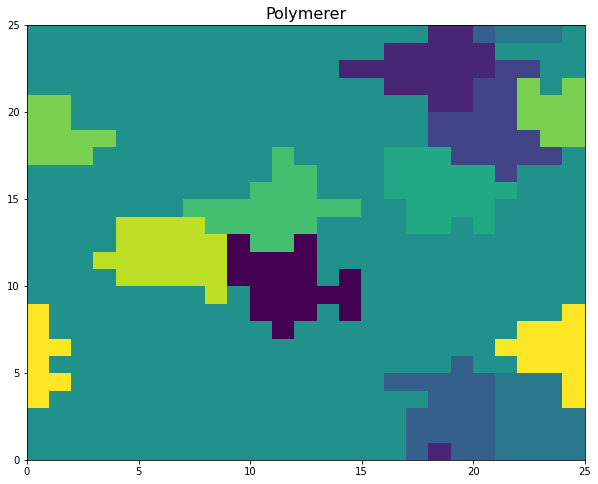

In [22]:
# Oppgave 2a
def generate_grid_of_polymers(N, M, L):
    #N: Størrelse på grid
    #M: Antall monomerer
    #L: multivalens
     
    grid = np.zeros((N,N), dtype=np.dtype('i2')) #Lager tomt grid av størrelse N*N

    m = -M  # Finner start verdi for whileløkka
    
    while m <= M:
        random_x = np.random.randint(0,N-1)   #Finner tilfeldige x og y koordinater
        random_y = np.random.randint(0,N-1)

        if grid[random_x][random_y] != 0:   #Prøver på nytt dersom det alt er en polymer på plassen
            pass 
        else:
            grid[random_x][random_y] = m 
            monomer_Positions = []  #Lager en tom liste som skal ta koordinater til monomerene
            monomer_Positions.append([random_x ,random_y])
            j = 1  #Finner startverdi for whileløkka

            while j < L:  #Kjører frem til lengden er nådd
                random_Monomer = random.choice(monomer_Positions) #Posisjon til tilfeldig monomer i monomer_Positions
                neighbors = get_neighbors_coordinates(N, random_Monomer[0], random_Monomer[1]) #Finner naboverdiene 
                neighbor_values = np.zeros(4) #Lager en tom array til naboverdiene
                solvent_position = [] #Lager en tom liste som skal ha koordinatene til posisjonene uten monomerer/polymerer
                for n in range (4):
                    neighbor_values[n] = grid[neighbors[n][0]][neighbors[n][1]] #Sjekker verdiene til koordinatene
                    if neighbor_values[n] == 0:  #Legger inn koordinatene til naboer uten monomerer i solvent_position
                        solvent_position.append([neighbors[n][0], neighbors[n][1]])
                if len(solvent_position) == 0: #Prøver på nytt dersom man ikke har noen naboer uten monomerer 
                    pass
                else:
                    random_Neighbor = random.choice(solvent_position) #Posisjon til et tilfeldig nabopunkt fylt med løsning 
                    grid[random_Neighbor[0]][random_Neighbor[1]] = m  #Gir nabopunktet samme verdi som polymeret
                    monomer_Positions.append(random_Neighbor)     #Legger nabopunktets koordinater inn i monomer_Positions
                    j += 1
            m += 1
    return grid 
   
polymer_grid = generate_grid_of_polymers(25, 5, 21)
visualize_grid(polymer_grid, "Polymerer", False)              

In [24]:
# Oppgave 2b
@jit(nopython=True)
def total_energy_polymers(grid_energy):
    grid = grid_energy.copy()
    total_energy = 0 # Definerer total_enery som E/alfa
    N = len(grid)
    
    i = 0
    j = 0
    while i < N:
        while j < N:
            neighbors = get_neighbors_coordinates(N, i, j)
            n = 0
            while n < 4:
                if grid[i][j] == grid[neighbors[n][0]][neighbors[n][1]]: #monomerer i samme polymer, gir ikke energi
                    n += 1
                elif grid[i][j] == 0 or grid[neighbors[n][0]][neighbors[n][1]] == 0: 
                    n += 1
                else:
                    total_energy += grid[i][j]*grid[neighbors[n][0]][neighbors[n][1]]*alfa_2 / abs(grid[i][j]*grid[neighbors[n][0]][neighbors[n][1]])
                    n += 1  
            j += 1
        j = 0
        i += 1
    #Tar hensyn til at samme koordinat telles to ganger, men kun 1 bånd eksisterer
    total_energy = total_energy/ 2 


    return total_energy


print("Den totale energien for polymer_grid er: " , total_energy_polymers(polymer_grid) , "J")


Den totale energien for polymer_grid er:  -2.138260895452135e-21 J


In [25]:
# Hjelpefunksjon, tar inn et grid og en polymerverdi og returnerer en liste over alle koordinater med denne polymerverdien
@jit(nopython=True)
def polymer_list(grid, poly_value):
    coordinates = []
    i = 0
    j = 0
    while i < len(grid):
        while j < len(grid):
            if grid[i][j] == poly_value:  # Sjekker om koordinatet har den ønskede polymerverdien
                coordinates.append([i,j]) # Legger til koordinatet
            j += 1
        j = 0
        i += 1
    return coordinates

In [26]:
# Oppgave 2c)
#Directions: [Down, Right, Up, Left] = [0, 1, 2, 3]
@jit(nopython=True)
def rigid_move(grid, polymer_value, direction):
    polymer = polymer_list(grid, polymer_value) #Lager liste over koordinatene til polymer
    original_grid = grid.copy() 
    N = len(grid)
    n = 0
    
    #Sjekke om det er mulig å flytte, om polymeret er i kontakt med et annet polymer som vil hindre forflytning
    while n < len(polymer):
        neighbor = get_neighbors_coordinates(N, polymer[n][0], polymer[n][1]) #Finner naboene til naboene til monomer i polymeret
        if original_grid[neighbor[direction][0]][neighbor[direction][1]] != 0 and original_grid[neighbor[direction][0]][neighbor[direction][1]] != polymer_value: #Dersom naboen i retningen vi vil flytte er et annet polymer vil ikke noe bli flyttet, og samme grid returneres
            return original_grid
        n += 1    
    
    #Dersom ingen av naboene var et annet polymer kan vi flytte polymeret
    m = 0
    moved_grid = grid.copy()
    while m < len(polymer): #Itererer gjennom alle monomerene i polymeret
        neighbor = get_neighbors_coordinates(N, polymer[m][0], polymer[m][1]) #Finner nabokoordinatene til monomeret
        moved_grid[neighbor[direction][0]][neighbor[direction][1]] = original_grid[polymer[m][0]][polymer[m][1]] #Flytter monomerverdien i den retningen vi skal bevege oss
        if original_grid[neighbor[(direction+2)%4][0]][neighbor[(direction+2)%4][1]] != 0 and original_grid[neighbor[(direction+2)%4][0]][neighbor[(direction+2)%4][1]] != polymer_value: 
            moved_grid[polymer[m][0]][polymer[m][1]] = 0 # Setter verdien vi har beveget oss fra lik 0 dersom den er i kontakt med et annt polymer
        else:
            moved_grid[polymer[m][0]][polymer[m][1]] = original_grid[neighbor[(direction+2)%4][0]][neighbor[(direction+2)%4][1]] #Setter verdien vi har beveget oss fra lik monomerverdien som lå der før
        m += 1

    
    return moved_grid


In [49]:
#Oppgave 2d)
@jit(nopython=True)
def Monte_Carlo_polymers_rigid(N_S,N, M,T, grid):

    epsilon = np.zeros(N_S - 1, dtype=np.dtype('double'))  # En tom liste over verdier
    E = total_energy_polymers(grid) #Regner ut den totale energien av den orginale griden
    epsilon[0] = E  #Setter det første elementet i den tomme lista over energier lik start energien
    
    for i in range(0,N_S-1):
        epsilon[i] = total_energy(grid) # Finner energien til griden
        new_grid = grid.copy() # Lager en kopi av griden
        polymer_value = 0 #Setter en startverdi for whileløkka, ønkser ikke poly_value = 0, skulle denne verdien velges kjøre løkka på ny
        while polymer_value == 0:
            polymer_value = np.random.randint(-M, M+1)
        direction = np.random.randint(0,4)
        new_grid = rigid_move(new_grid, polymer_value, direction)    
        E_new = total_energy_polymers(new_grid) # Finner energien til den nye griden  
        if E_new < epsilon[i]: #Sjekker med energiene om vi skal forflytte oss til den nye gridden
            grid = new_grid
        elif np.random.random() < np.exp(-(1/(k_B*T))*(E_new - epsilon[i])):
            grid = new_grid
         
    return grid, epsilon

In [50]:
polymer_grid_before_MC = generate_grid_of_polymers(25, 5, 15)

polymer_grid_after_MC, E_rigid = Monte_Carlo_polymers_rigid(30000,25, 5,200, polymer_grid_before_MC)

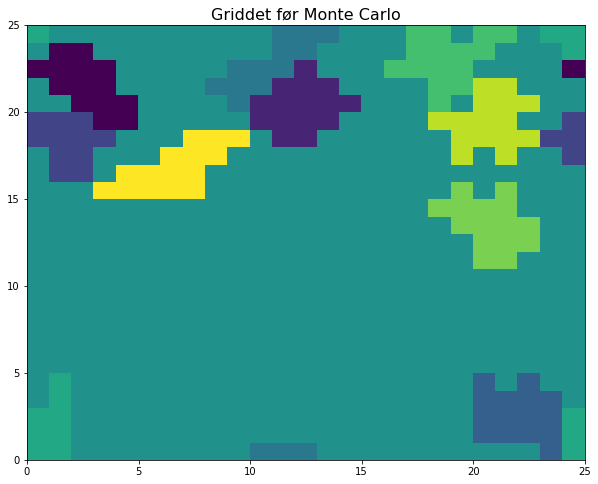

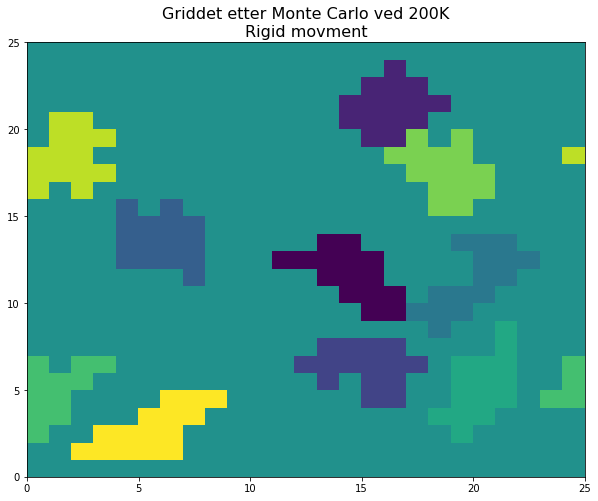

In [51]:
visualize_grid(polymer_grid_before_MC, "Griddet før Monte Carlo") 

visualize_grid(polymer_grid_after_MC, "Griddet etter Monte Carlo ved 200K\nRigid movment") 

I gridet etter gjennomført Monte Carlo med Rigid movment ser man at to eller flere polymerer samles, og danner clusters. En annen ting verdt merke seg er at funksjonen i oppgave 2c har medført at polymerene holder på formene sine, selv om de har flyttet på seg. Ingen av polymerene er disformerte. Kjøretiden til funksjonen i oppgave 2d er lengre enn kjøretiden for Monte Carlo for monomerer. Hovedårsaken til dette er at når en forflytning først skjer må hele polymeret forflyttes ikke bare et enkelt monomer. En annen viktig årsak til at kjøretiden øker er at for alle monomerene i polymeret må det først sjekkes om en forflytning er mulig. Tiden skjæres litt ned av at det ikke gjennomføres like mange steg som ved Monte Carlo for monomerer som for polymerer(30 000 mot 50 000).

In [30]:
#Oppgave 2f)
#Hjelpefunksjon for å finne størrelsen til polymeret
@jit(nopython=True)
def check_size_polymer(grid_to_check,i,j,poly_value, size = 1):
    #Funksjonen tar inn et grid, koordinatene til et monomoer i polymeret [i,j], polymerverdien og en startstørrelse.
    grid = grid_to_check.copy()
    N = len(grid)
    neighbors = get_neighbors_coordinates(N,i,j) #Finner nabokoordinatene til punktet vi tar inn

    grid[i][j] = 0 #Setter verdien til koordinatet lik null
    for n in range(4): #Sjekker alle naboene til koordinatet
        if poly_value == grid[neighbors[n][0]][neighbors[n][1]]: #Sjekker om naboen har polymerverdien
            size += 1      #Øker størrelsen til polymeret med 1
            size, grid = check_size_polymer(grid, neighbors[n][0], neighbors[n][1],poly_value,size) #Bruker rekursjon for å telle opp alle sammenhengende monomerer i polymeret
    return size, grid

#Funksjon som sjekker om polymeret er knekt ved å sjekke om den gjennomsnittlige clustersizen er lik L 
@jit(nopython=True)
def is_polymer_broken(grid, poly_value, L):
    list_of_monomers = polymer_list(grid, poly_value) #Finner koordinatene til polymeret
    size_of_the_polymer = check_size_polymer(grid,list_of_monomers[0][0],list_of_monomers[0][1],poly_value)[0] #Finner størrelsen til polymeret
    if size_of_the_polymer != L: #Hvis størrelsen ikke er lik L vil polymeret være knekt
        return True
    else:
        return False
    

In [31]:
#Oppgave 2e
#Directions: [Down, Right, Up, Left] = [0, 1, 2, 3]
#Lager en hjelpefunksjon som sjekker om en kollosjon med et annet polymer vil oppstå
@jit(nopython=True)
def able_to_move(grid,i,j, polymer_value, direction): # Tar inn gridd, koordinater, polymerverdi og retningen vi ønsker å sjekke
    N = len(grid)
    neighbor = get_neighbors_coordinates(N, i, j)[direction] #Finner nabokoordinatet i retningen vi ønsker å bevege oss
    neighbor_value = grid[neighbor[0]][neighbor[1]] #Finner hvilken verdi nabokoordinatet har fått tildelt
    if neighbor_value == polymer_value: #Sjekker om nabokoordinatet er en del av polynomet vårt
        if able_to_move(grid,neighbor[0], neighbor[1] ,polymer_value, direction): #Bruker rekursjon til å bevege oss til enden av polymeret
            return True
        else:
            return False 
    elif neighbor_value == 0: #Ser om polymeret er i kontakt med et annet polymer.
        return True           #Dersom neighbor_value = 0, vil det ikke være kontakt
    else: 
        return False          #Ellers er det kontakt med et annet polymer
    
@jit(nopython=True)
def medium_flexibility_move(grid, polymer_value, direction):
    list_of_monomers = polymer_list(grid, polymer_value) #Lager liste over koordinatene til monomerene til polymeret, vha hjelpefunksjon
    N = len(grid)                  # Finner lengden av gridet
    L = len (list_of_monomers)     # Finner størrelsen av polymeret, skal brukes for å sjekke om polymeren er ødelagt
    n = 0
    
    moved_grid = grid.copy()
    original_grid = grid.copy()
    
    while n < len(list_of_monomers):
        #Finner nabokoordinatet i ønsket retning
        neighbor = get_neighbors_coordinates(N, list_of_monomers[n][0], list_of_monomers[n][1]) 

        # Sjekker om monomeret vil kunne bevege seg, altså om det er i kontakt med en annen polymere som forhindrer forflytning
        if able_to_move(original_grid, list_of_monomers[n][0], list_of_monomers[n][1], polymer_value, direction):
            #Flytter monomeren dersom det er tillatt
            moved_grid[neighbor[direction][0]][neighbor[direction][1]] = original_grid[list_of_monomers[n][0]][list_of_monomers[n][1]]
            
            if original_grid[neighbor[(direction+2)%4][0]][neighbor[(direction+2)%4][1]] != 0 and original_grid[neighbor[(direction+2)%4][0]][neighbor[(direction+2)%4][1]] != polymer_value: 
                # Setter verdien vi har beveget oss fra lik 0 dersom den er i kontakt med et annt polymer
                moved_grid[list_of_monomers[n][0]][list_of_monomers[n][1]] = 0

            else:
                # Setter verdien til koordinatet vi har beveget oss i fra lik naboverdien i motsatt retning av bevegelsen
                moved_grid[list_of_monomers[n][0]][list_of_monomers[n][1]] = original_grid[neighbor[(direction+2)%4][0]][neighbor[(direction+2)%4][1]]    
        n += 1        
    
    # Modifisering: Flytter ikke polymeret dersom det ødelegges
    if is_polymer_broken(moved_grid, polymer_value, L): #Sjekker om polymeren ødelegges, dersom dette skjer gjennomfører vi ikke forflytningen
        return original_grid
    else: 
        return moved_grid

In [52]:
#Oppgave 2g)
@jit(nopython=True)
def Monte_Carlo_polymers_medium_flexible(N_S,N, M,T, grid):
    epsilon = np.zeros(N_S - 1, dtype=np.dtype('double'))  # En tom liste over verdier
    E = total_energy_polymers(grid) #Regner ut den totale energien av den orginale griden
    epsilon[0] = E  #Setter det første elementet i den tomme lista over energier lik start energien
    
    for i in range(0,N_S-1):
        epsilon[i] = total_energy(grid) # Finner energien til griden
        new_grid = grid.copy() # Lager en kopi av griden
        polymer_value = 0 #Setter en startverdi for whileløkka, ønkser ikke poly_value = 0, skulle denne verdien velges kjøre løkka på ny
        while polymer_value == 0:
            polymer_value = np.random.randint(-M, M+1)
        direction = np.random.randint(0,4)
        new_grid = medium_flexibility_move(new_grid, polymer_value, direction)    
        E_new = total_energy_polymers(new_grid) # Finner energien til den nye griden  
        if E_new < epsilon[i]: #Sjekker med energiene om vi skal forflytte oss til den nye gridden
            grid = new_grid
        elif np.random.random() < np.exp(-(1/(k_B*T))*(E_new - epsilon[i])):
            grid = new_grid
         
    return grid, epsilon

In [53]:
# polymer_grid_before_MC er definert i Oppgave 2d
# polymer_grid_after_MC og E_polymer er definert i Oppgave 2d og en monte Carlo på polymer_grid_before_MC med rigid movment

grid_before_MC = generate_grid_of_polymers(25, 5, 15)
grid_MC_rigid, E_rigid = Monte_Carlo_polymers_rigid(30000,25, 5, 200, grid_before_MC)
grid_MC_medium_flexible, E_medium_flexible = Monte_Carlo_polymers_medium_flexible(30000,25, 5,200, grid_before_MC)


Text(0.5, 0.98, 'Grid før og etter Monte Carlo v. 200 K \n Med rigid og medium flexible move\n\n ')

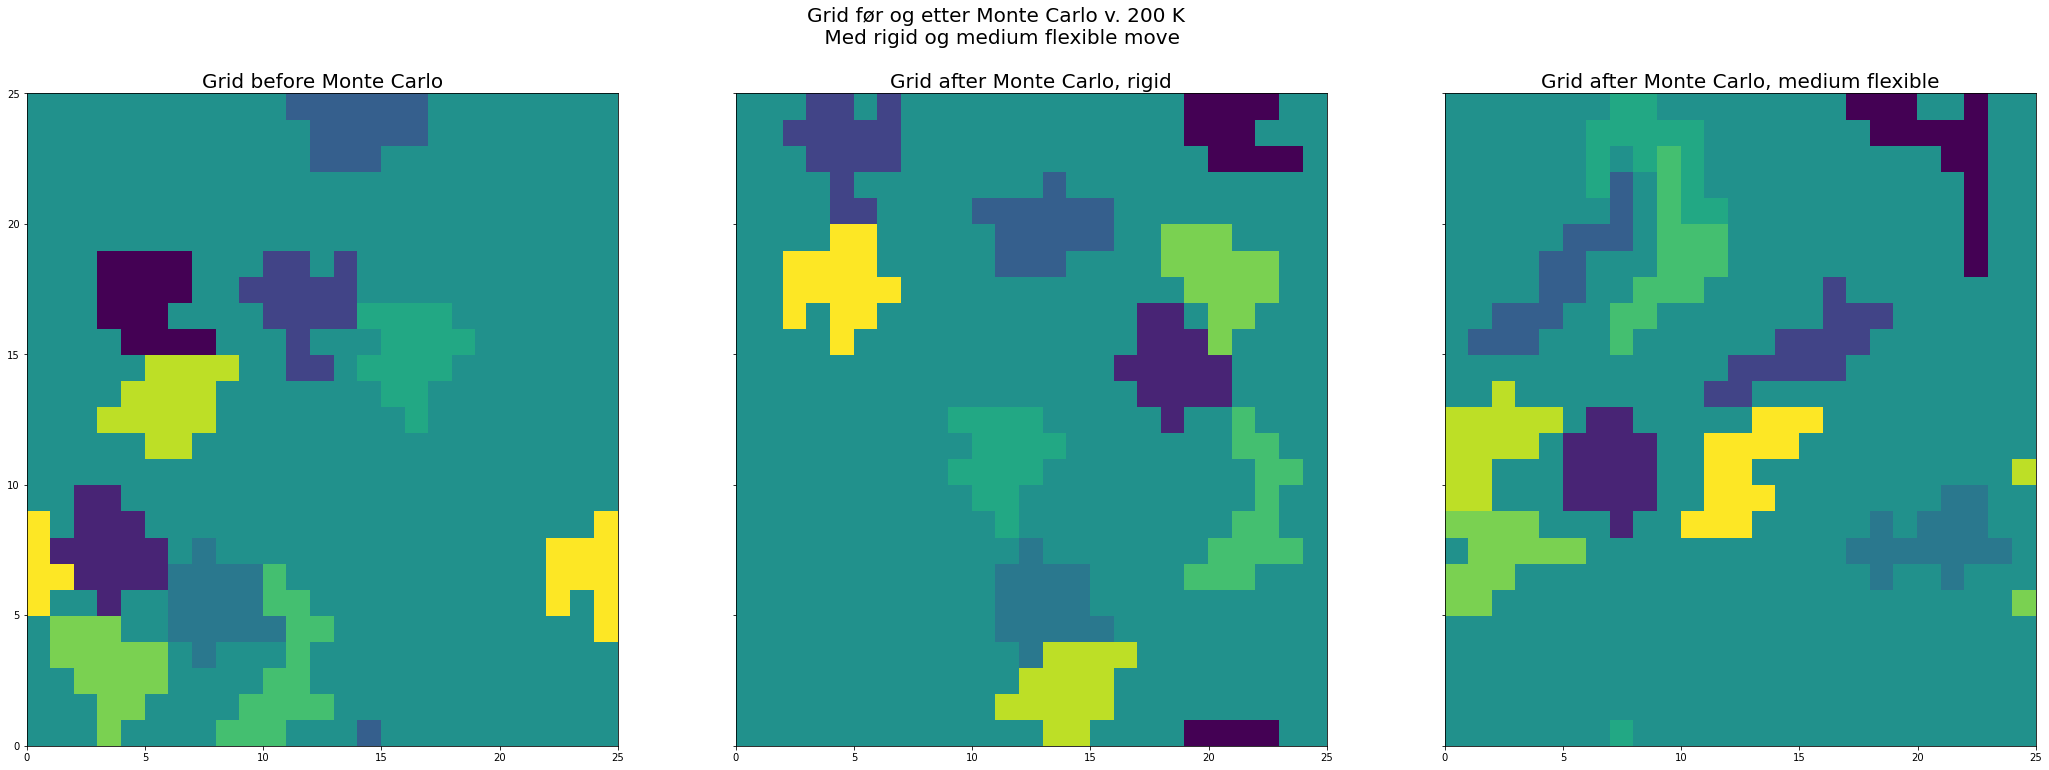

In [55]:
#plotter griddet før og etter clustering ved siden av hverandre
fig, axs = plt.subplots(1, 3, figsize=(36, 12), sharey=True)
axs[0].set_title('Grid before Monte Carlo', size='20')
axs[0].pcolormesh(grid_before_MC[::-1,])

axs[1].set_title('Grid after Monte Carlo, rigid', size='20')
axs[1].pcolormesh(grid_MC_rigid[::-1,])

axs[2].set_title('Grid after Monte Carlo, medium flexible', size='20')
axs[2].pcolormesh(grid_MC_medium_flexible[::-1,])
fig.suptitle('Grid før og etter Monte Carlo v. 200 K \n Med rigid og medium flexible move\n\n ', size = '20')

Over har vi plottet 3 grid, et av det orginale gridet, et etter at gridet har gjennomgått Monte Carlo med rigid movement og et etter gjennomført Monte Carlo med medium flexible movement. Som tidligere nevnt ser man at ved rigid movment vil polymerene danne clusters, men holde på formene sine. I likhet med rigid movment vil også polymerene i medium flexible movement danne clusters. Årsaken til dette er at dette vil være et energiminima. I motsetning til polymerene i rigid movement vil ikke polymerene i medium flexible movment holde på formene sine. De vil strekke seg ut og bli lange og tynne. Årsaken til dette er at polymerene vil få et større overflateareal, som vil føre til flere mulige kontaktpunkter. Flere kontaktpunkter vil kunne føre til lavere energi. Vi ser at formene i medium flexible move tilpasser seg hverandre, og har flere kontaktpunkter. I plottet under kan man se at energien til gridet etter medium flexible movement er lavere enn energien til griddet etter rigid movement. 

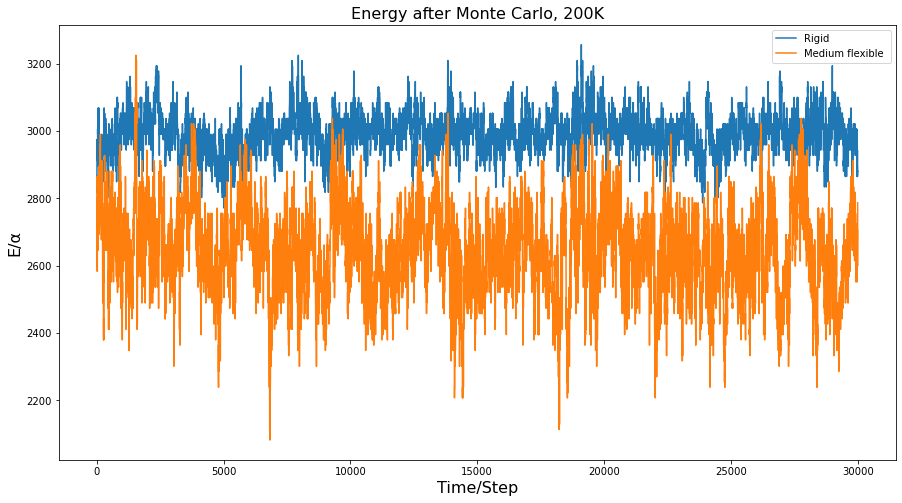

In [57]:
plt.figure(figsize=(15, 8))
plt.plot(E_rigid/alfa_2) 
plt.plot(E_medium_flexible/alfa_2) 
plt.legend(['Rigid', 'Medium flexible '])
plt.ylabel('E/α',fontsize=16 )
plt.xlabel("Time/Step", fontsize=16)
plt.title("Energy after Monte Carlo, 200K",fontsize=16)
plt.show()

In [42]:
#Oppgave 2h
#Definerer tallverdier vi skal bruke
T = 300
t_r = 1000
N = 30
M = 5
t_equil = 10000 #Valgt størrelse
n = 50   #Valgt størrelse

Basert på tidligere oppgaver hvor en formel for $t_{equil}$ ble oppgitt, regnet vi oss frem til at en $t_{equil} \approx 10 000$ vil gi oss tilstrekkelig med steg for å oppnå likevekt. Når det kom til valg av n gjorde vi som nevnt tidligere; vi balanserte feil og kjøretid. Med dette kom vi frem til at n = 50, og dermed 50 000 ekstra steg vil gi lav nok feil, i tillegg til en akseptabel kjøretid. 

In [43]:
@jit(nopython=True)
def clusters(grid): #Hjelpefunksjon som gir antall clusters i et grid
    N = len (grid)
    list_of_values = []
    
    for i in range(0,N):
        for j in range (0,N):
            if grid[i][j] not in list_of_values:
                if grid[i][j] != 0:
                    list_of_values.append(grid[i][j])
    clusternumber = len(list_of_values)
    return clusternumber

In [44]:
'''Lager en funksjon som vil returnere tre lister, en over gjennomsnittlige clustersizes, 
en over gjennomsnittlig antall clusters og en liste over lengder.
Vil bruke disse listene til å plotte ⟨d⟩/L og ⟨m⟩ sfa. L'''

def cluster_information(N, T, M, n, t_equil, t_r):
    # N: lengden til grid
    # T: temperatur
    # M: antall polymerer
    # n: antall målinger gjort etter likevekt er nådd
    # t_equil: antall tidssteg gjort før målingene starter (nådd likevekt)
    # t_r: antall tidssteg mellom hver måling
    
    cluster_sizes = [] #Liste over <d>/L
    list_of_number_of_clusters = [] #Liste over antall klusters i hvert grid <m>
    length = [] #Liste over L-verdiene

    for L in range(3,40,3):
        length.append(L) #Legger til L i listen over lengder
    
        grid = generate_grid_of_polymers(N,M,L)
        grid_MC, energy_MC = Monte_Carlo_polymers_flexible(t_equil, N, M,T, grid) #Kjøre MC frem til likevekt
        
        #Finner gjennomsnittlig clusterstørrelse/L griden etter oppnådd likevekt
        grid_MC_standard = standardized_grid(grid_MC.copy())
        grid_MC_standard = iteration(grid_MC_standard)
        average_cluster_size = cluster_size(grid_MC_standard)/L
        sum_average_cluster_size = average_cluster_size   #Legger gjennomsnittlig clusterstørrelse inn i en sum
        
        #Finner antall clusters i griden etter oppnådd likevekt
        number_of_clusters = clusters(grid_MC_standard)   
        sum_number_of_clusters = number_of_clusters   #Legger antall clusters inn i en sum
        
        #Kjører MC n ganger med antall steg på t_r, og legger til gjennomsnittlig clusterstørrelse og og antall clusters inn i summene 
        for i in range(n):
            grid_MC, energy_MC = Monte_Carlo_polymers_flexible(t_r, N, M,T, grid_MC) #For hver n kjører vi MC med t_r steg
    
            grid_MC_standard = standardized_grid(grid_MC.copy())
            grid_MC_standard = iteration(grid_MC_standard)
            average_cluster_size = cluster_size(grid_MC_standard)/L
            sum_average_cluster_size += average_cluster_size
            
            number_of_clusters = clusters(grid_MC_standard)
            sum_number_of_clusters += number_of_clusters
            
    
        cluster_sizes.append(sum_average_cluster_size/n) #Legger til gjennomsnittlig cluster størrelse i tilsvarende liste
        list_of_number_of_clusters.append(sum_number_of_clusters/n) #Legger til gjennomsnittlig antall clusters i tilsvarende liste
    
    return cluster_sizes, list_of_number_of_clusters, length



In [45]:
cluster_sizes, list_of_number_of_clusters, length = cluster_information(N, T, M, n, t_equil, t_r)

Text(0.5, 1.0, 'Gjennomsnittelig clustersize og gjennomsnittlig antall clusters')

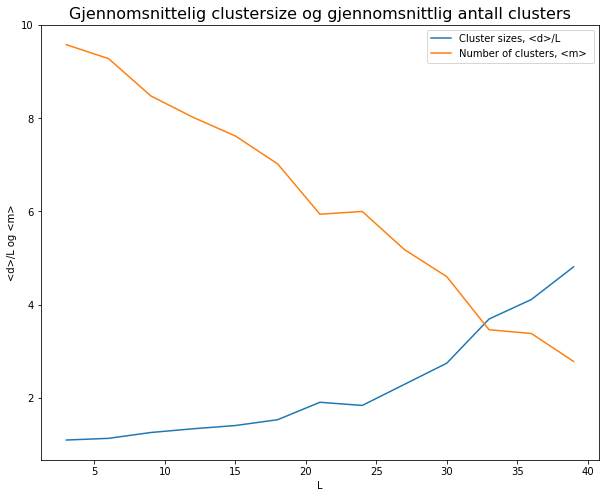

In [56]:
plt.figure(figsize=(10, 8))   #Bestemmer figurstørrelsen
plt.plot(length, cluster_sizes)
plt.plot(length, list_of_number_of_clusters)
plt.legend(['Cluster sizes, <d>/L', 'Number of clusters, <m> '])
plt.xlabel("L")
plt.ylabel("<d>/L og <m>")
plt.title("Gjennomsnittelig clustersize og gjennomsnittlig antall clusters",fontsize=16)

Ser at antall clusters er størst for lavere verdier av L og blir mindre for høyere verdier av L, mens størrelsen på clusterene er minst for lave L og blir større. Et høyt antall clusters er naturlig for små polymerer da de ikke tar opp mye plass, og det er mindre sannsynlig at de vil komme i kontakt med hverandre. Etterhvert som polymerene vokser, øker også sannsynligheten for at de vil komme i kontakt med hverandre. Dette fører til at størrelsen på clusterene vil øke, mens antallet vil minke.
Ved bruk av ridig move istedenfor flexible move tror vi ikke at vi vil få store forskjeller. Årsaken til dette er at når to polymerer er i kontakt danner de clusters, uavhengig av hvor mange kontaktpunkter de har.
For ulike kjøringer forventer vi at det er størst forskjell i gjennomsnittlig clustersize og gjennomsnittlig antall clusters ved L verdier rundt spennet 15-30. Da er clusterene store nok til at de ofte kan treffe på hverandre, men de er små nok til at de også har rom til å flytte på seg uten å treffe på hverande. 
La oss sette L konstant, og heller endre på parameteren N. Ved lave verdier av N forventer vi få clusters av stor størrelse. Etterhvert som verdien av N øker forventer vi også en økning i antall clusters og en reduksjon i størrelsen. Dette er grunnet at mer rom på likt antall polymerer.

__Konklusjon__

Ved studier av monomererers bevegelse under ulike temperaturer, ved bruk av Metropolis algoritmen, har vi sett at deres bevegelse er temperaturavhengig. For lave temperaturer dannes det i stor grad clusters, noe som leder til et energiminima. I kontrast med de lave temperaturene, vil vi for høye temperaturer få spredning av monomerene i griddet. Dette skyldes at det er større sannsynlighet for ugunstige forflytninger ved høyere temperaturer. Dermed vil energien til gridet som undergår Monte Carlo ved høye temperaturer ligge høyere på energigrafen enn gridet som undergår Monte Carlo ved lave temperaturer. Ved undersøkelse av gjennomsnittlig clustersize for ulike temperaturer fant vi at gjennomsnittlig clustersize sank ved stigende temperaturer. 

Polymerer er en cluster av monomerer, og deres bevegelse er avhengig av deres størrelse og form. Vi har studert deres bevegelse for ridig og medium flexibility move, og tilhørende energier. Ut fra dette har vi sett at energien ble lavere ved bruk av medium flexibility move grunnet flere kontaktpunkter mellom polymerene. Videre undersøkte vi gjennomsnittelig clustersize og gjennomsnittlig antall clusters som funksjon av polymerenes lengde. Ved små polymerer vil den gjennomsnittlig antall clusters være stor og gjennomsnittelig clustersize være liten. I takt med at lengden på polymerene stiger vil gjennomsnittlig antall clusters minke, mens gjennomsnittelig clustersize vil øke.